In [1]:
# Face Recognition using Siamese Networks with Contrastive Loss
# LFW-deepfunneled Dataset Implementation

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

TensorFlow version: 2.19.0
GPU Available: []


In [2]:
# Dataset Configuration
DATASET_PATH = r"c:\Users\quyha\Git\Doan3\lfw-deepfunneled\lfw-deepfunneled"
IMG_SIZE = (105, 105)  # Standard LFW image size
IMG_CHANNELS = 3

class LFWDatasetProcessor:
    def __init__(self, dataset_path, img_size=(105, 105)):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.person_images = {}
        self.person_list = []
        
    def load_dataset(self, min_images_per_person=2):
        """Load dataset and organize by person"""
        print("Loading LFW dataset...")
        
        for person_name in os.listdir(self.dataset_path):
            person_path = os.path.join(self.dataset_path, person_name)
            
            if os.path.isdir(person_path):
                images = []
                for img_file in os.listdir(person_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(person_path, img_file)
                        images.append(img_path)
                
                # Only include persons with at least min_images_per_person images
                if len(images) >= min_images_per_person:
                    self.person_images[person_name] = images
                    self.person_list.append(person_name)
        
        print(f"Loaded {len(self.person_list)} persons with {sum(len(imgs) for imgs in self.person_images.values())} total images")
        return self.person_images
    
    def preprocess_image(self, img_path):
        """Load and preprocess a single image"""
        try:
            # Load image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize to target size
            img = cv2.resize(img, self.img_size)
            
            # Normalize to [0, 1]
            img = img.astype(np.float32) / 255.0
            
            return img
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            return None
    
    def create_pairs(self, num_pairs=10000):
        """Create positive and negative pairs for training"""
        pairs = []
        labels = []
        
        print(f"Creating {num_pairs} pairs...")
        
        for i in range(num_pairs):
            if i % 2 == 0:  # Create positive pair
                # Select a random person with at least 2 images
                person = random.choice([p for p in self.person_list if len(self.person_images[p]) >= 2])
                img_paths = self.person_images[person]
                
                # Select two different images of the same person
                img1_path, img2_path = random.sample(img_paths, 2)
                
                img1 = self.preprocess_image(img1_path)
                img2 = self.preprocess_image(img2_path)
                
                if img1 is not None and img2 is not None:
                    pairs.append([img1, img2])
                    labels.append(1)  # Same person
                
            else:  # Create negative pair
                # Select two different persons
                person1, person2 = random.sample(self.person_list, 2)
                
                img1_path = random.choice(self.person_images[person1])
                img2_path = random.choice(self.person_images[person2])
                
                img1 = self.preprocess_image(img1_path)
                img2 = self.preprocess_image(img2_path)
                
                if img1 is not None and img2 is not None:
                    pairs.append([img1, img2])
                    labels.append(0)  # Different persons
            
            if (i + 1) % 1000 == 0:
                print(f"Created {i + 1} pairs...")
        
        return np.array(pairs), np.array(labels)

# Initialize dataset processor
dataset_processor = LFWDatasetProcessor(DATASET_PATH, IMG_SIZE)

In [3]:
def create_base_network(input_shape):
    """Create the base network for feature extraction"""
    
    # Use ResNet50 as backbone with pre-trained weights
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Fine-tune from the 5th block onwards
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    # Add custom layers on top
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(x)  # L2 normalization
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

def contrastive_loss(y_true, y_pred, margin=1.0):
    """Contrastive loss function for Siamese networks"""
    y_true = tf.cast(y_true, tf.float32)
    
    # Calculate Euclidean distance
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    
    # Contrastive loss formula
    loss = tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

def euclidean_distance(vectors):
    """Compute Euclidean distance between two vectors"""
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_network(input_shape):
    """Create Siamese network architecture"""
    
    # Define input layers for the two images
    left_input = Input(shape=input_shape, name='left_input')
    right_input = Input(shape=input_shape, name='right_input')
    
    # Create base network (shared weights)
    base_network = create_base_network(input_shape)
    
    # Generate encodings for both inputs
    encoded_left = base_network(left_input)
    encoded_right = base_network(right_input)
    
    # Calculate distance between encodings
    distance = layers.Lambda(euclidean_distance, name='distance')([encoded_left, encoded_right])
    
    # Create and compile the Siamese model
    siamese_model = Model(inputs=[left_input, right_input], outputs=distance)
    
    return siamese_model, base_network

# Model configuration
input_shape = (*IMG_SIZE, IMG_CHANNELS)
print(f"Input shape: {input_shape}")

# Create Siamese network
siamese_model, base_network = create_siamese_network(input_shape)

# Compile the model
siamese_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=contrastive_loss,
    metrics=['accuracy']
)

print("Siamese Network Architecture:")
siamese_model.summary()

Input shape: (105, 105, 3)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

Siamese Network Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │ 24,809,216 │ left_input[0][0], │
│ (Functional)        │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (Lambda)   │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,809,216 (94.64 MB)

 Trainable params: 10,148,736 (38.71 MB)

 Non-trainable params: 14,660,480 (55.93 MB)

In [4]:
# Load dataset
person_images = dataset_processor.load_dataset(min_images_per_person=2)

# Show dataset statistics
total_persons = len(person_images)
total_images = sum(len(imgs) for imgs in person_images.values())
avg_images_per_person = total_images / total_persons

print(f"\nDataset Statistics:")
print(f"Total persons: {total_persons}")
print(f"Total images: {total_images}")
print(f"Average images per person: {avg_images_per_person:.2f}")

# Show some examples
print(f"\nTop 10 persons by number of images:")
sorted_persons = sorted(person_images.items(), key=lambda x: len(x[1]), reverse=True)
for i, (person, images) in enumerate(sorted_persons[:10]):
    print(f"{i+1}. {person}: {len(images)} images")

Loading LFW dataset...
Loaded 1680 persons with 9164 total images

Dataset Statistics:
Total persons: 1680
Total images: 9164
Average images per person: 5.45

Top 10 persons by number of images:
1. George_W_Bush: 530 images
2. Colin_Powell: 236 images
3. Tony_Blair: 144 images
4. Donald_Rumsfeld: 121 images
5. Gerhard_Schroeder: 109 images
6. Ariel_Sharon: 77 images
7. Hugo_Chavez: 71 images
8. Junichiro_Koizumi: 60 images
9. Jean_Chretien: 55 images
10. John_Ashcroft: 53 images


Creating training pairs...
Creating 8000 pairs...
Created 1000 pairs...
Created 2000 pairs...
Created 3000 pairs...
Created 4000 pairs...
Created 5000 pairs...
Created 6000 pairs...
Created 7000 pairs...
Created 8000 pairs...
Created 8000 pairs
Positive pairs (same person): 4000
Negative pairs (different persons): 4000

Train set: 6400 pairs
Validation set: 1600 pairs

Sample pairs:


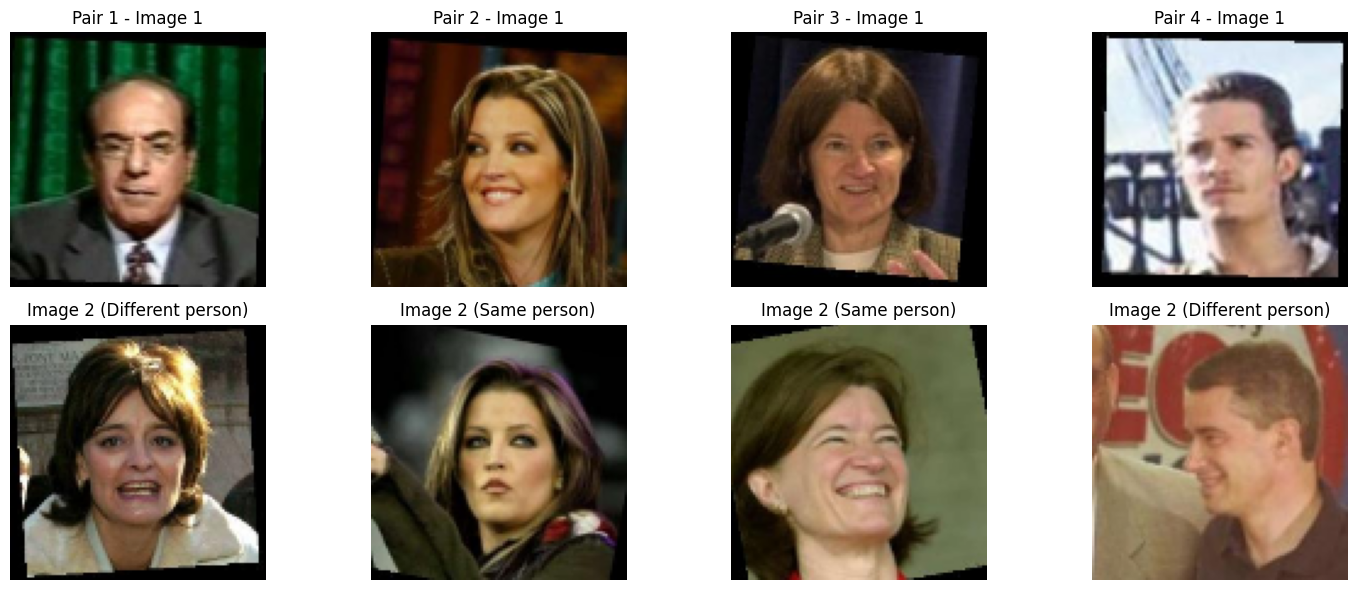

In [5]:
# Create training pairs
print("Creating training pairs...")
pairs, labels = dataset_processor.create_pairs(num_pairs=8000)

print(f"Created {len(pairs)} pairs")
print(f"Positive pairs (same person): {np.sum(labels)}")
print(f"Negative pairs (different persons): {len(labels) - np.sum(labels)}")

# Split into train and validation sets
train_pairs, val_pairs, train_labels, val_labels = train_test_split(
    pairs, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nTrain set: {len(train_pairs)} pairs")
print(f"Validation set: {len(val_pairs)} pairs")

# Function to visualize pairs
def visualize_pairs(pairs, labels, num_pairs=4):
    """Visualize sample pairs"""
    fig, axes = plt.subplots(2, num_pairs, figsize=(15, 6))
    
    for i in range(num_pairs):
        idx = random.randint(0, len(pairs) - 1)
        pair = pairs[idx]
        label = labels[idx]
        
        # First image
        axes[0, i].imshow(pair[0])
        axes[0, i].set_title(f"Pair {i+1} - Image 1")
        axes[0, i].axis('off')
        
        # Second image
        axes[1, i].imshow(pair[1])
        axes[1, i].set_title(f"Image 2 ({'Same' if label == 1 else 'Different'} person)")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some sample pairs
print("\nSample pairs:")
visualize_pairs(train_pairs, train_labels, num_pairs=4)

In [6]:
# Prepare data for training
def prepare_data(pairs, labels):
    """Convert pairs to the format expected by the Siamese network"""
    left_images = np.array([pair[0] for pair in pairs])
    right_images = np.array([pair[1] for pair in pairs])
    return [left_images, right_images], labels

# Prepare training and validation data
X_train, y_train = prepare_data(train_pairs, train_labels)
X_val, y_val = prepare_data(val_pairs, val_labels)

print(f"Training data shapes:")
print(f"Left images: {X_train[0].shape}")
print(f"Right images: {X_train[1].shape}")
print(f"Labels: {y_train.shape}")

# Define callbacks for training optimization
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_siamese_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("\nCallbacks configured:")
print("- EarlyStopping: Stops training if validation loss doesn't improve for 10 epochs")
print("- ModelCheckpoint: Saves the best model based on validation loss")
print("- ReduceLROnPlateau: Reduces learning rate when validation loss plateaus")

Training data shapes:
Left images: (6400, 105, 105, 3)
Right images: (6400, 105, 105, 3)
Labels: (6400,)

Callbacks configured:
- EarlyStopping: Stops training if validation loss doesn't improve for 10 epochs
- ModelCheckpoint: Saves the best model based on validation loss
- ReduceLROnPlateau: Reduces learning rate when validation loss plateaus


In [7]:
# Training configuration
EPOCHS = 50
BATCH_SIZE = 32

print("Starting training...")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Optimizer: Adam (lr=0.0001)")
print(f"Loss function: Contrastive Loss")

# Train the model
history = siamese_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training...
Epochs: 50
Batch size: 32
Optimizer: Adam (lr=0.0001)
Loss function: Contrastive Loss
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.5088 - loss: 0.3369
Epoch 1: val_loss improved from inf to 0.31037, saving model to best_siamese_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 172s 790ms/step - accuracy: 0.5087 - loss: 0.3367 - val_accuracy: 0.5000 - val_loss: 0.3104 - learning_rate: 1.0000e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.4901 - loss: 0.2543
Epoch 2: val_loss improved from 0.31037 to 0.29374, saving model to best_siamese_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 741ms/step - accuracy: 0.4900 - loss: 0.2543 - val_accuracy: 0.4919 - val_loss: 0.2937 - learning_rate: 1.0000e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.4338 - loss: 0.2452
Epoch 3: val_loss improved from 0.29374 to 0.26586, saving model to best_siamese_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 169s 848ms/step - accuracy: 0.4338 - loss: 0.2452 - val_accuracy: 0.4137 - val_loss: 0.2659 - learning_rate: 1.0000e-04
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.3938 - loss: 0.2353
Epoch 4: val_loss did not improve from 0.26586
200/200 ━━━━━━━━━━━━━━━━━━━━ 149s 745ms/step - accuracy: 0.3938 - loss: 0.2353 - val_accuracy: 0.4825 - val_loss: 0.3306 - learning_rate: 1.0000e-04
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.3674 - loss: 0.2282
Epoch 5: val_loss did not improve from 0.26586
200/200 ━━━━━━━━━━━━━━━━━━━━ 146s 732ms/step - accuracy: 0.3674 - loss: 0.2282 - val_accuracy: 0.4437 - val_loss: 0.2694 - learning_rate: 1.0000e-04
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.3597 - loss: 0.2239
Epoch 6: val_loss did not improve from 0.26586
200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 739ms/step - accuracy: 0.3597 - loss: 0.2239 - val_accuracy: 0.4200 - val_loss: 0.2739 - learning_rate: 1.0000e-04

200/200 ━━━━━━━━━━━━━━━━━━━━ 144s 723ms/step - accuracy: 0.3384 - loss: 0.2141 - val_accuracy: 0.4144 - val_loss: 0.2549 - learning_rate: 1.0000e-04
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.3131 - loss: 0.2088
Epoch 9: val_loss did not improve from 0.25495
200/200 ━━━━━━━━━━━━━━━━━━━━ 145s 724ms/step - accuracy: 0.3131 - loss: 0.2088 - val_accuracy: 0.4094 - val_loss: 0.2565 - learning_rate: 1.0000e-04
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.2949 - loss: 0.2017
Epoch 10: val_loss did not improve from 0.25495
200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 740ms/step - accuracy: 0.2949 - loss: 0.2017 - val_accuracy: 0.4137 - val_loss: 0.2710 - learning_rate: 1.0000e-04
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.3012 - loss: 0.2008
Epoch 11: val_loss improved from 0.25495 to 0.23111, saving model to best_siamese_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 149s 746ms/step - accuracy: 0.3011 - loss: 0.2008 - val_accuracy: 0.3700 - val_loss: 0.2311 - learning_rate: 1.0000e-04
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.2837 - loss: 0.1926
Epoch 12: val_loss did not improve from 0.23111
200/200 ━━━━━━━━━━━━━━━━━━━━ 144s 722ms/step - accuracy: 0.2837 - loss: 0.1927 - val_accuracy: 0.3969 - val_loss: 0.2721 - learning_rate: 1.0000e-04
Epoch 13/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.2640 - loss: 0.1869
Epoch 13: val_loss did not improve from 0.23111
200/200 ━━━━━━━━━━━━━━━━━━━━ 149s 746ms/step - accuracy: 0.2640 - loss: 0.1869 - val_accuracy: 0.3438 - val_loss: 0.2323 - learning_rate: 1.0000e-04
Epoch 14/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.2510 - loss: 0.1795
Epoch 14: val_loss did not improve from 0.23111
200/200 ━━━━━━━━━━━━━━━━━━━━ 144s 718ms/step - accuracy: 0.2510 - loss: 0.1796 - val_accuracy: 0.3850 - val_loss: 0.2596 - learning_rate: 1.00

200/200 ━━━━━━━━━━━━━━━━━━━━ 144s 719ms/step - accuracy: 0.2412 - loss: 0.1749 - val_accuracy: 0.3175 - val_loss: 0.2172 - learning_rate: 1.0000e-04
Epoch 17/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.2539 - loss: 0.1738
Epoch 17: val_loss did not improve from 0.21719
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 712ms/step - accuracy: 0.2539 - loss: 0.1738 - val_accuracy: 0.3638 - val_loss: 0.2416 - learning_rate: 1.0000e-04
Epoch 18/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.2325 - loss: 0.1664
Epoch 18: val_loss did not improve from 0.21719
200/200 ━━━━━━━━━━━━━━━━━━━━ 145s 723ms/step - accuracy: 0.2325 - loss: 0.1664 - val_accuracy: 0.3363 - val_loss: 0.2286 - learning_rate: 1.0000e-04
Epoch 19/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.2289 - loss: 0.1633
Epoch 19: val_loss improved from 0.21719 to 0.21314, saving model to best_siamese_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 143s 713ms/step - accuracy: 0.2289 - loss: 0.1633 - val_accuracy: 0.3081 - val_loss: 0.2131 - learning_rate: 1.0000e-04
Epoch 20/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.2131 - loss: 0.1580
Epoch 20: val_loss did not improve from 0.21314
200/200 ━━━━━━━━━━━━━━━━━━━━ 143s 716ms/step - accuracy: 0.2131 - loss: 0.1580 - val_accuracy: 0.3275 - val_loss: 0.2276 - learning_rate: 1.0000e-04
Epoch 21/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.1992 - loss: 0.1510
Epoch 21: val_loss did not improve from 0.21314
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 713ms/step - accuracy: 0.1992 - loss: 0.1510 - val_accuracy: 0.4013 - val_loss: 0.2585 - learning_rate: 1.0000e-04
Epoch 22/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.1969 - loss: 0.1470
Epoch 22: val_loss did not improve from 0.21314
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 712ms/step - accuracy: 0.1969 - loss: 0.1470 - val_accuracy: 0.3231 - val_loss: 0.2203 - learning_rate: 1.00

200/200 ━━━━━━━━━━━━━━━━━━━━ 143s 717ms/step - accuracy: 0.1846 - loss: 0.1406 - val_accuracy: 0.3081 - val_loss: 0.2089 - learning_rate: 1.0000e-04
Epoch 25/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.1785 - loss: 0.1398
Epoch 25: val_loss improved from 0.20890 to 0.20186, saving model to best_siamese_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 144s 722ms/step - accuracy: 0.1785 - loss: 0.1398 - val_accuracy: 0.3044 - val_loss: 0.2019 - learning_rate: 1.0000e-04
Epoch 26/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.1730 - loss: 0.1369
Epoch 26: val_loss did not improve from 0.20186
200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 813ms/step - accuracy: 0.1730 - loss: 0.1369 - val_accuracy: 0.3781 - val_loss: 0.2497 - learning_rate: 1.0000e-04
Epoch 27/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.1791 - loss: 0.1368
Epoch 27: val_loss did not improve from 0.20186
200/200 ━━━━━━━━━━━━━━━━━━━━ 141s 705ms/step - accuracy: 0.1791 - loss: 0.1368 - val_accuracy: 0.3663 - val_loss: 0.2401 - learning_rate: 1.0000e-04
Epoch 28/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.1727 - loss: 0.1318
Epoch 28: val_loss did not improve from 0.20186
200/200 ━━━━━━━━━━━━━━━━━━━━ 140s 701ms/step - accuracy: 0.1727 - loss: 0.1318 - val_accuracy: 0.4550 - val_loss: 0.3071 - learning_rate: 1.00

In [8]:
# Training visualization and evaluation functions
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy (if available)
    if 'accuracy' in history.history:
        ax2.plot(history.history['accuracy'], label='Training Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, threshold=0.5):
    """Evaluate model performance"""
    print("Evaluating model...")
    
    # Get predictions (distances)
    distances = model.predict(X_test)
    distances = distances.flatten()
    
    # Convert distances to binary predictions
    predictions = (distances < threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    
    print(f"\nEvaluation Results (threshold={threshold}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Average distance for same person: {distances[y_test == 1].mean():.4f}")
    print(f"Average distance for different persons: {distances[y_test == 0].mean():.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, predictions, target_names=['Different', 'Same']))
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Different', 'Same'], 
                yticklabels=['Different', 'Same'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return accuracy, distances, predictions

def find_optimal_threshold(model, X_val, y_val):
    """Find optimal threshold for classification"""
    distances = model.predict(X_val).flatten()
    
    thresholds = np.arange(0.1, 2.0, 0.05)
    accuracies = []
    
    for threshold in thresholds:
        predictions = (distances < threshold).astype(int)
        accuracy = accuracy_score(y_val, predictions)
        accuracies.append(accuracy)
    
    best_threshold = thresholds[np.argmax(accuracies)]
    best_accuracy = max(accuracies)
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies)
    plt.axvline(x=best_threshold, color='r', linestyle='--', 
                label=f'Best threshold: {best_threshold:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Threshold vs Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Optimal threshold: {best_threshold:.3f}")
    print(f"Best accuracy: {best_accuracy:.4f}")
    
    return best_threshold, best_accuracy

def test_on_new_pairs(model, dataset_processor, num_test_pairs=100):
    """Test model on new pairs"""
    print(f"Creating {num_test_pairs} test pairs...")
    
    # Create new test pairs
    test_pairs, test_labels = dataset_processor.create_pairs(num_pairs=num_test_pairs)
    X_test, y_test = prepare_data(test_pairs, test_labels)
    
    print(f"Test set: {len(test_pairs)} pairs")
    print(f"Positive pairs: {np.sum(test_labels)}")
    print(f"Negative pairs: {len(test_labels) - np.sum(test_labels)}")
    
    return X_test, y_test

print("Evaluation functions ready!")

Evaluation functions ready!


Plotting training history...


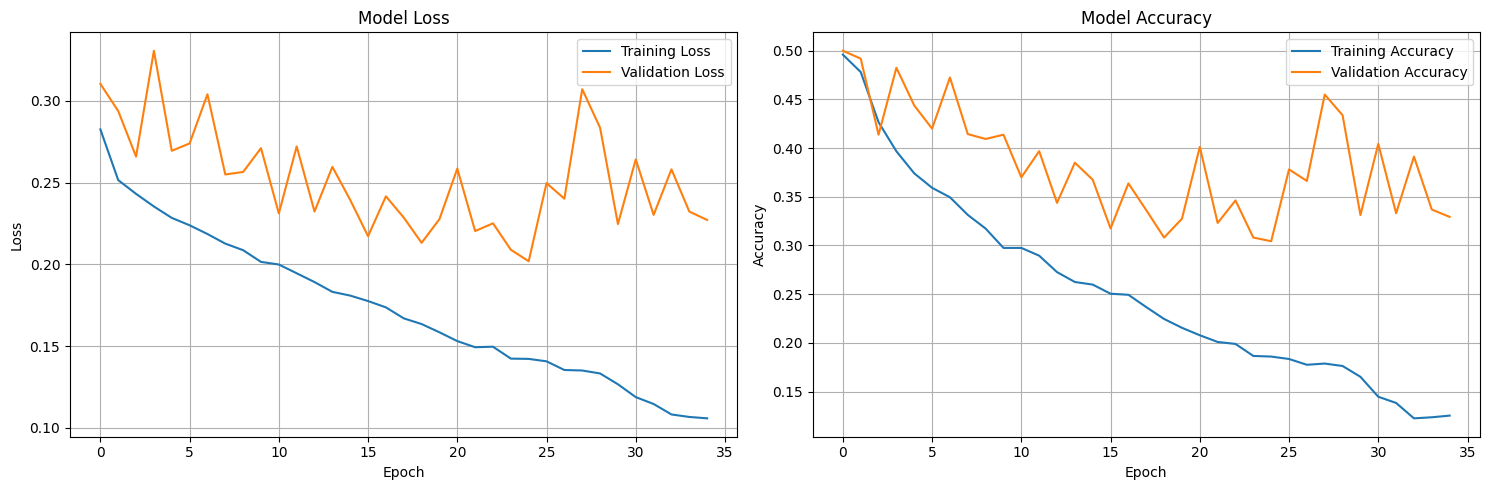


Finding optimal threshold...
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 447ms/step


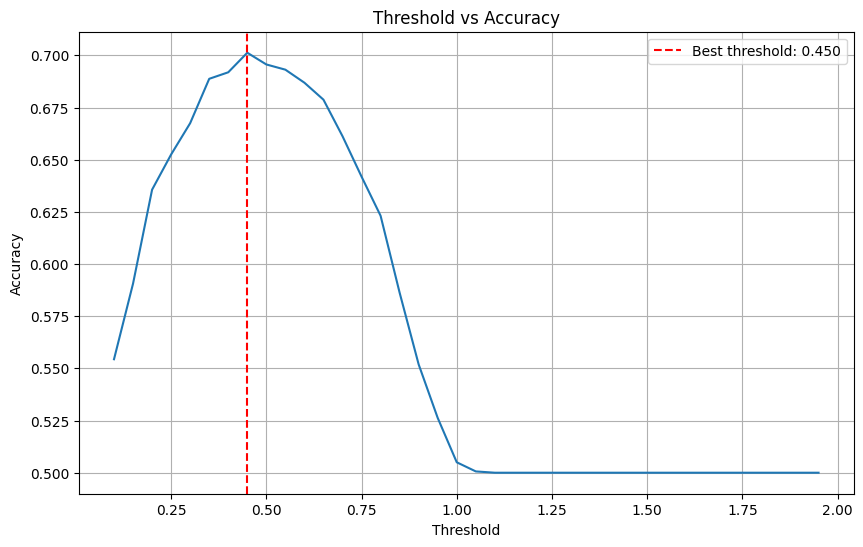

Optimal threshold: 0.450
Best accuracy: 0.7013

Evaluating on validation set with optimal threshold (0.450)...
Evaluating model...
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 434ms/step

Evaluation Results (threshold=0.45000000000000007):
Accuracy: 0.7013
Average distance for same person: 0.3322
Average distance for different persons: 0.5877

Classification Report:
              precision    recall  f1-score   support

   Different       0.71      0.69      0.70       800
        Same       0.70      0.72      0.71       800

    accuracy                           0.70      1600
   macro avg       0.70      0.70      0.70      1600
weighted avg       0.70      0.70      0.70      1600



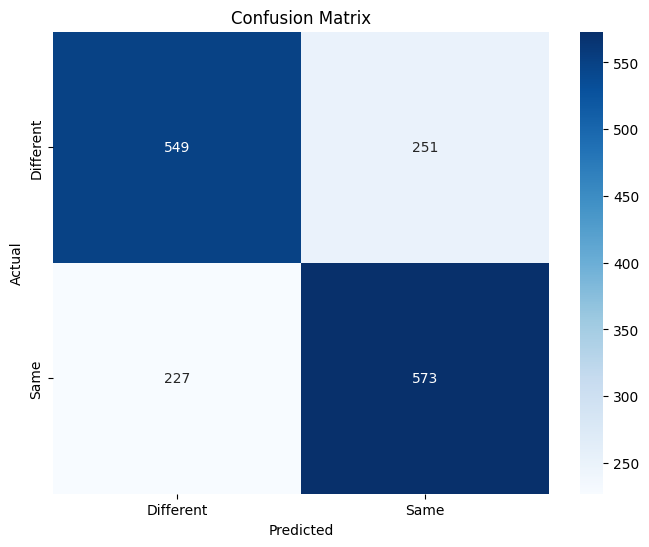

Creating 500 test pairs...
Creating 500 pairs...
Test set: 500 pairs
Positive pairs: 250
Negative pairs: 250

Evaluating on test set with optimal threshold (0.450)...
Evaluating model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 600ms/step

Evaluation Results (threshold=0.45000000000000007):
Accuracy: 0.7000
Average distance for same person: 0.3440
Average distance for different persons: 0.5898

Classification Report:
              precision    recall  f1-score   support

   Different       0.70      0.69      0.70       250
        Same       0.70      0.71      0.70       250

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.70       500
weighted avg       0.70      0.70      0.70       500



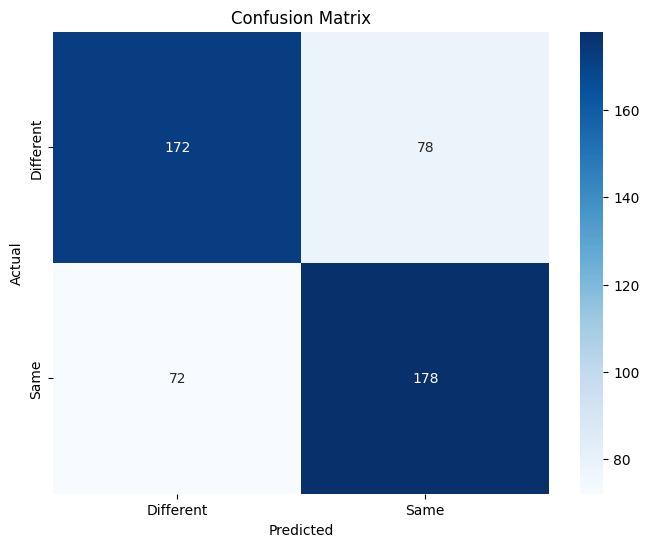

In [10]:
# Plot training history
print("Plotting training history...")
plot_training_history(history)

# Find optimal threshold
print("\nFinding optimal threshold...")
optimal_threshold, best_val_accuracy = find_optimal_threshold(siamese_model, X_val, y_val)

# Evaluate on validation set with optimal threshold
print(f"\nEvaluating on validation set with optimal threshold ({optimal_threshold:.3f})...")
val_accuracy, val_distances, val_predictions = evaluate_model(
    siamese_model, X_val, y_val, threshold=optimal_threshold
)

# Create and test on new unseen pairs
X_test, y_test = test_on_new_pairs(siamese_model, dataset_processor, num_test_pairs=500)

print(f"\nEvaluating on test set with optimal threshold ({optimal_threshold:.3f})...")
test_accuracy, test_distances, test_predictions = evaluate_model(
    siamese_model, X_test, y_test, threshold=optimal_threshold
)